<a href="https://colab.research.google.com/github/Adham1704/programming-Tobias-Schaffer/blob/main/Ibrahim_Copy_Lab08_Plant_Disease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Download dataset
!pip install -q gdown

# plant_leave_diseases_train.zip
!gdown https://drive.google.com/uc?id=1MCQ2ldiKZUeVM1rVw1gPlBaX43AJB3R0

# plant_leave_diseases_test.zip
!gdown https://drive.google.com/uc?id=1yqvfEVeb0IAutxZK83_wUoUWm5apYSF8

import zipfile

# Unzip data
with zipfile.ZipFile('plant_leave_diseases_train.zip', 'r') as zip_file:
    zip_file.extractall()

with zipfile.ZipFile('plant_leave_diseases_test.zip', 'r') as zip_file:
    zip_file.extractall()

Downloading...
From (original): https://drive.google.com/uc?id=1MCQ2ldiKZUeVM1rVw1gPlBaX43AJB3R0
From (redirected): https://drive.google.com/uc?id=1MCQ2ldiKZUeVM1rVw1gPlBaX43AJB3R0&confirm=t&uuid=b604099a-ba07-4827-b96a-21db2a7a0622
To: /content/plant_leave_diseases_train.zip
100% 682M/682M [00:07<00:00, 85.9MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1yqvfEVeb0IAutxZK83_wUoUWm5apYSF8
From (redirected): https://drive.google.com/uc?id=1yqvfEVeb0IAutxZK83_wUoUWm5apYSF8&confirm=t&uuid=07f0f4ee-b067-4f16-be9b-ff85645cc815
To: /content/plant_leave_diseases_test.zip
100% 170M/170M [00:01<00:00, 103MB/s]


Found 34756 images belonging to 38 classes.
Class 0 → 404 samples
Class 1 → 397 samples
Class 2 → 176 samples
Class 3 → 1053 samples
Class 4 → 961 samples
Class 5 → 673 samples
Class 6 → 547 samples
Class 7 → 763 samples
Class 8 → 328 samples
Class 9 → 631 samples
Class 10 → 744 samples
Class 11 → 885 samples
Class 12 → 756 samples
Class 13 → 688 samples
Class 14 → 271 samples
Class 15 → 3524 samples
Class 16 → 1470 samples
Class 17 → 231 samples
Class 18 → 638 samples
Class 19 → 946 samples
Class 20 → 640 samples
Class 21 → 640 samples
Class 22 → 97 samples
Class 23 → 237 samples
Class 24 → 3258 samples
Class 25 → 1175 samples
Class 26 → 710 samples
Class 27 → 292 samples
Class 28 → 1361 samples
Class 29 → 640 samples
Class 30 → 1222 samples
Class 31 → 609 samples
Class 32 → 1133 samples
Class 33 → 1072 samples
Class 34 → 899 samples
Class 35 → 3428 samples
Class 36 → 239 samples
Class 37 → 1018 samples


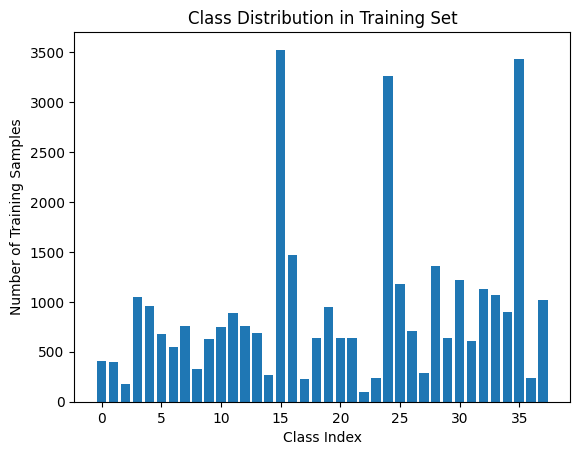

Found 8673 images belonging to 38 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

# Paths to your folders
train_data_dir = 'plant_leave_diseases_train'

# Image settings
img_size = (256, 256) #try to make it faster processing
batch_size = 32 #64

# Create a ImageDataGenerator with validation split
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    #rotation_range=15,           # rotate images
    #width_shift_range=0.1,       # shift horizontally
    #height_shift_range=0.1,      # shift vertically
    #shear_range=0.05,             # shear transformation
    #zoom_range=0.1,              # zoom in/out
    #horizontal_flip=True,        # flip horizontally
    #fill_mode='nearest'          # fill strategy
)

# Training data generator
train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Count how many samples per class
labels = train_generator.classes
class_counts = Counter(labels)

# Print class index and number of samples
for cls_index, count in sorted(class_counts.items()):
    print(f"Class {cls_index} → {count} samples")

# Optional: visualize
import matplotlib.pyplot as plt

plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Class Index")
plt.ylabel("Number of Training Samples")
plt.title("Class Distribution in Training Set")
plt.show()


# Validation data generator

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

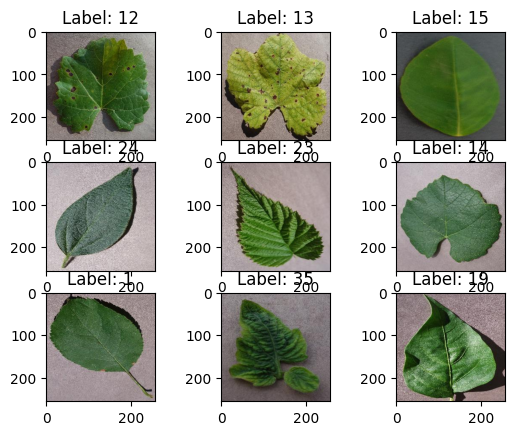

In [ ]:
#Check images being fed to model

import matplotlib.pyplot as plt
for images, labels in train_generator: # Iterate directly over the generator
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        # Find the index of the highest value in the one-hot encoded label
        plt.title(f"Label: {labels[i].argmax()}")
    break # Take only one batch
plt.show()

In [ ]:
# Build improved CNN model with regularization
model = Sequential([
    Input(shape=(img_size[0], img_size[1], 3)),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),    # Strong dropout on dense layer
    Dense(train_generator.num_classes, activation='softmax')
])

# Compile and train
from tensorflow.keras.optimizers import Adam
model.compile(optimizer= Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#Train Model

# EarlyStopping callback to avoid overfitting
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# Train model with more epochs
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights  # ← handles imbalance
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1087/1087 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.2414 - loss: 2.9118

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1087/1087 ━━━━━━━━━━━━━━━━━━━━ 97s 86ms/step - accuracy: 0.2415 - loss: 2.9112 - val_accuracy: 0.7106 - val_loss: 1.0401 - learning_rate: 0.0010
Epoch 2/10
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 90s 83ms/step - accuracy: 0.6077 - loss: 1.3030 - val_accuracy: 0.8050 - val_loss: 0.6686 - learning_rate: 0.0010
Epoch 3/10
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 86s 79ms/step - accuracy: 0.7295 - loss: 0.8479 - val_accuracy: 0.8483 - val_loss: 0.5130 - learning_rate: 0.0010
Epoch 4/10
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 92s 85ms/step - accuracy: 0.7819 - loss: 0.6465 - val_accuracy: 0.8318 - val_loss: 0.5320 - learning_rate: 0.0010
Epoch 5/10
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 85s 78ms/step - accuracy: 0.8175 - loss: 0.5248 - val_accuracy: 0.8596 - val_loss: 0.4730 - learning_rate: 0.0010
Epoch 6/10
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 87s 80ms/step - accuracy: 0.8419 - loss: 0.4731 - val_accuracy: 0.8900 - val_loss: 0.3780 - learning_rate: 0.0010
Epoch 7/10
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 93s 85ms/step - accuracy: 0.8671 

272/272 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step


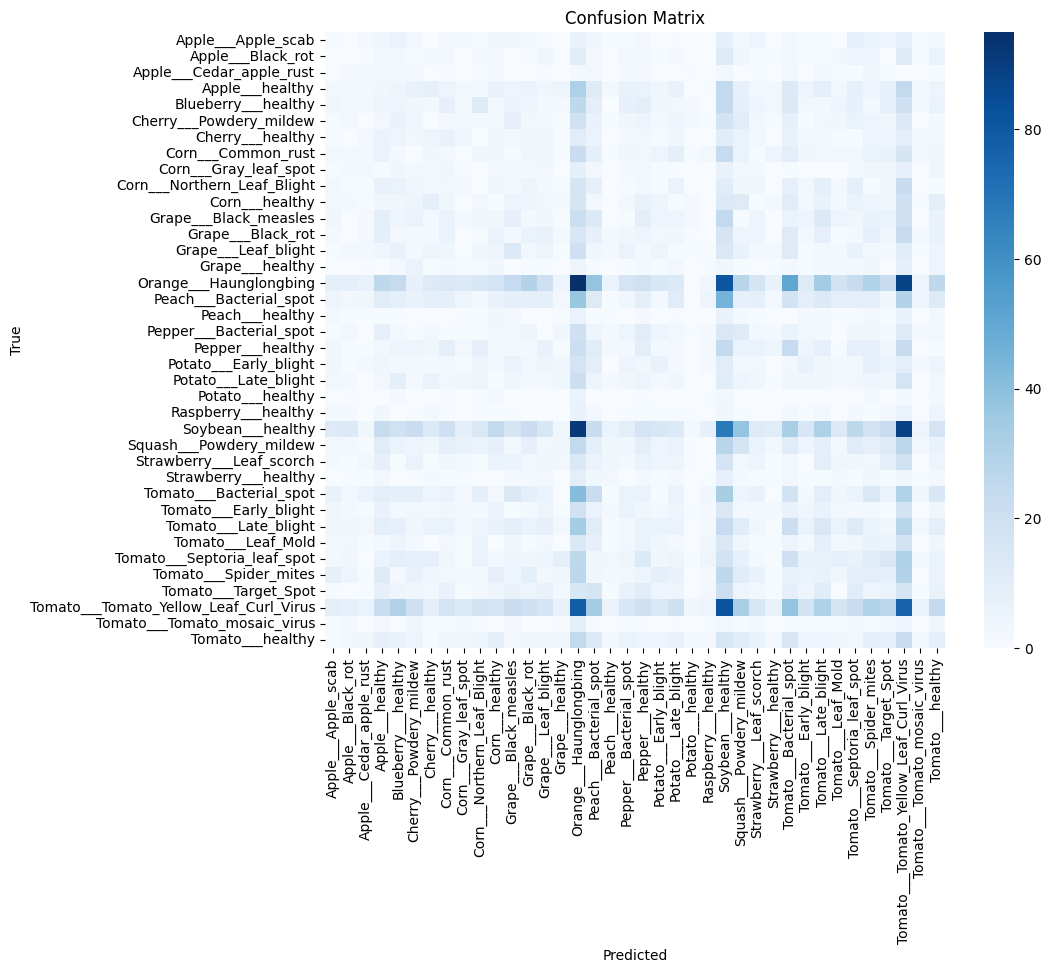

Classification Report:
                                         precision    recall  f1-score   support

                    Apple___Apple_scab     0.0088    0.0100    0.0093       100
                     Apple___Black_rot     0.0000    0.0000    0.0000        99
              Apple___Cedar_apple_rust     0.0278    0.0455    0.0345        44
                       Apple___healthy     0.0153    0.0152    0.0152       263
                   Blueberry___healthy     0.0224    0.0208    0.0216       240
               Cherry___Powdery_mildew     0.0226    0.0238    0.0232       168
                      Cherry___healthy     0.0347    0.0368    0.0357       136
                    Corn___Common_rust     0.0104    0.0105    0.0105       190
                 Corn___Gray_leaf_spot     0.0097    0.0122    0.0108        82
           Corn___Northern_Leaf_Blight     0.0000    0.0000    0.0000       157
                        Corn___healthy     0.0052    0.0054    0.0053       185
               

In [ ]:
# ========== STEP 5: EVALUATION ==========

# Predictions & true labels
y_true = val_generator.classes
y_pred_probs = model.predict(val_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Class index mapping
idx2class = {v: k for k, v in train_generator.class_indices.items()}
class_names = [idx2class[i] for i in range(len(idx2class))]

# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification report
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print("Classification Report:\n", report)

# Save to files
import pandas as pd
pd.DataFrame(cm, index=class_names, columns=class_names).to_csv('confusion_matrix.csv')
with open('classification_report.txt', 'w') as f:
    f.write(report)


Saved confusion_matrix.csv and classification_report.txt ✔️


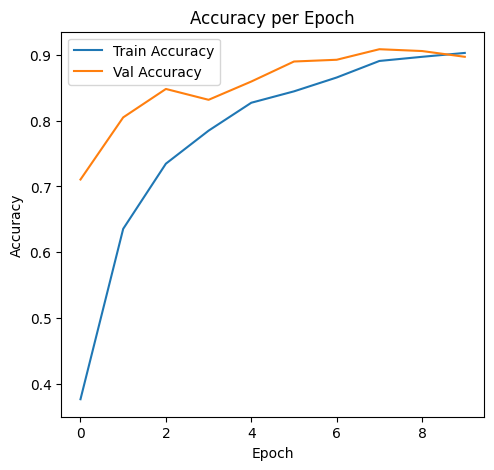

In [ ]:
# === 6) Save results to files ===
import pandas as pd
pd.DataFrame(cm, index=class_names, columns=class_names) \
  .to_csv('confusion_matrix.csv')
with open('classification_report.txt','w') as f:
    f.write(report)

print("Saved confusion_matrix.csv and classification_report.txt ✔️")

# ========== STEP 6: PLOT TRAINING HISTORY ==========

hist = history.history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(hist['accuracy'], label='Train Accuracy')
plt.plot(hist['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
import os
import shutil

# Create the expected 'unknown' subfolder
os.makedirs('plant_leave_diseases_test/ibrahim', exist_ok=True)

# Move all images into that subfolder
for fname in os.listdir('plant_leave_diseases_test'):
    src_path = os.path.join('plant_leave_diseases_test', fname)
    dst_path = os.path.join('plant_leave_diseases_test/ibrahim', fname)
    if os.path.isfile(src_path):
        shutil.move(src_path, dst_path)

print("✅ Moved test images into 'ibrahim/' subfolder.")


✅ Moved test images into 'ibrahim/' subfolder.


In [ ]:
# prompt: run the model, on the plant_leave_diseases_test, and generate a csv file, with the result, with an option to change the filename, it doesnt have classes/label

filename = 'submission_12501300.csv' #@param {type:"string"}

test_data_dir = 'plant_leave_diseases_test'

# Create a test data generator without data augmentation, only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=img_size,
    batch_size=1,
    class_mode=None, # No labels in the test set
    shuffle=False # Keep the original order of samples
)

# Make predictions on the test set
test_pred_probs = model.predict(test_generator, verbose=1)
test_predictions = np.argmax(test_pred_probs, axis=1)

# Get the list of image file paths
image_paths = test_generator.filepaths

# Create a DataFrame with image paths and predictions
results_df = pd.DataFrame({'image_path': image_paths, 'predicted_class_index': test_predictions})

# Save the DataFrame to a CSV file
results_df.to_csv(filename, index=False)

print(f"Predictions saved to {filename}")

Found 10876 images belonging to 1 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10876/10876 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step
Predictions saved to submission_12501300.csv
